In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#raw_data = pd.read_csv(f"/content/drive/MyDrive/Major Project 8th sem/Code/data/AAPL_1years_15Min.csv")
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Final_csv/RELIANCE.csv')

In [ ]:
time = []
for i in raw_data['Datetime']:
    date_list = i.split("+")
    time.append(date_list[0])

raw_data['Datetime']=time

In [ ]:
# rename columns according to our older convention
raw_data.rename(
    {'Datetime':'time',
     'Open': 'open',
    'High': 'high',
    'Low' : 'low',
    'Close':'close',
    'Volume' : 'volume'},
    axis=1,
    inplace=True)

In [ ]:
print(raw_data.shape)
raw_data.head()

(6404, 7)


,time,open,high,low,close,volume,Trading_code
0,2021-04-26 09:15:00,1920.00,1930.00,1912.00,1926.85,1061804,RELIANCE
1,2021-04-26 09:30:00,1927.00,1936.10,1925.05,1935.05,652372,RELIANCE
2,2021-04-26 09:45:00,1935.20,1949.75,1935.05,1949.25,707257,RELIANCE
3,2021-04-26 10:00:00,1949.15,1961.60,1949.10,1955.00,915519,RELIANCE
4,2021-04-26 10:15:00,1955.05,1958.20,1947.60,1950.95,609119,RELIANCE


In [ ]:
open_ds = raw_data.loc[:, ['time', 'open']]
high_ds = raw_data.loc[:, ['time', 'high']]
low_ds = raw_data.loc[:, ['time', 'low']]
close_ds = raw_data.loc[:, ['time', 'close']]
volume_ds = raw_data.loc[:, ['time', 'volume']]

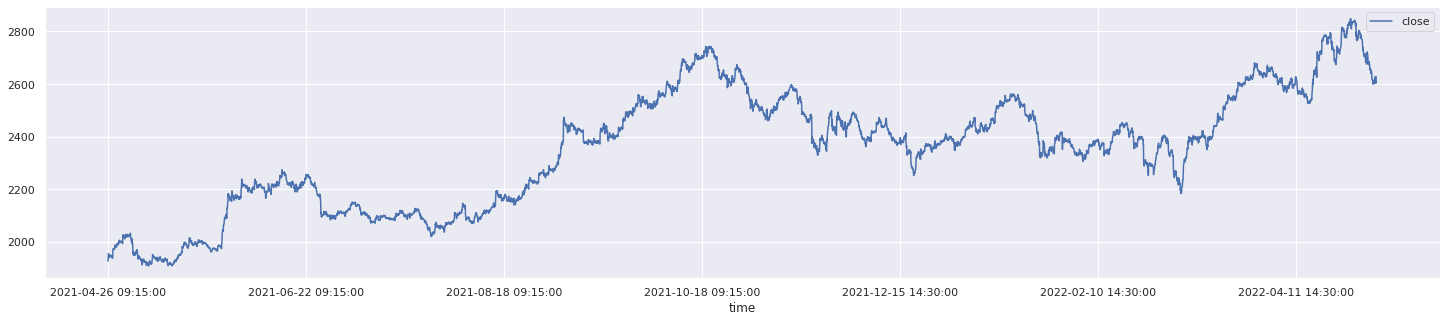

In [ ]:
close_ds.plot(x='time', y='close', figsize=(25, 5))

In [ ]:
# ema and vwap

from time import time
from datetime import datetime

"""
  Parameters
    d - previous number of data points to use for EMA
    price - stock price list
  Returns
    list of EMA of all points starting from the dth data point
"""
def calculate_ema(d, price) :
  print(f" Days {d} \n Length of prices {len(price)}")
  # formula https://www.investopedia.com/terms/e/ema.asp
  ema = []                                    # stores the ema starting from the dth data point i.e corresponding to price[d]
  ema_yesterday = sum(price[:d])/d            # sma of first d days, this will serve as the EMA of yesterday
  multiplier = 2/(d+1)                        # multiplier 
  for i in range(d,len(price)):
    ema_today = price[i]*multiplier + ema_yesterday*(1-multiplier)  
    ema.append(ema_today)
    ema_yesterday = ema_today
  print(f" Length of EMA list {len(ema)}")
  return ema



"""
  Parameters
    df - original dataframe
  Returns
    list of vwap
"""

def calculate_vwap(df):
  
  time_format = "%Y-%m-%d %H:%M:%S"
  
  sum_pv = 0
  sum_volume = 0
  
  vwap = []
  
  previous_day = datetime.strptime(df["time"][0], time_format).day

  for i in range(len(df)):
    
    current_day = datetime.strptime(df["time"][i], time_format).day

    if(current_day!=previous_day):
      sum_pv = 0
      sum_volume = 0

    previous_day = current_day

    sum_pv += ((df["high"][i] + df["low"][i] + df["close"][i])/3) * df["volume"][i]
    sum_volume += df["volume"][i]
    vwap.append(sum_pv/sum_volume)
  return vwap

In [ ]:
# price list
price = list(close_ds.drop('time', axis=1).values)
print(f"len prices = {len(price)}")

# ema taking 10 previous points for calculation
ema = calculate_ema(10,price)
print(f"len ema = {len(ema)}")

vwap = calculate_vwap(raw_data)
print(f"len vwap = {len(vwap)}")

len prices = 6404
 Days 10 
 Length of prices 6404
 Length of EMA list 6394
len ema = 6394
len vwap = 6404


In [ ]:
# make all ema, vwap, prices lists of equal length 
price = price[-len(ema):]
vwap = vwap[-len(ema):]

No handles with labels found to put in legend.


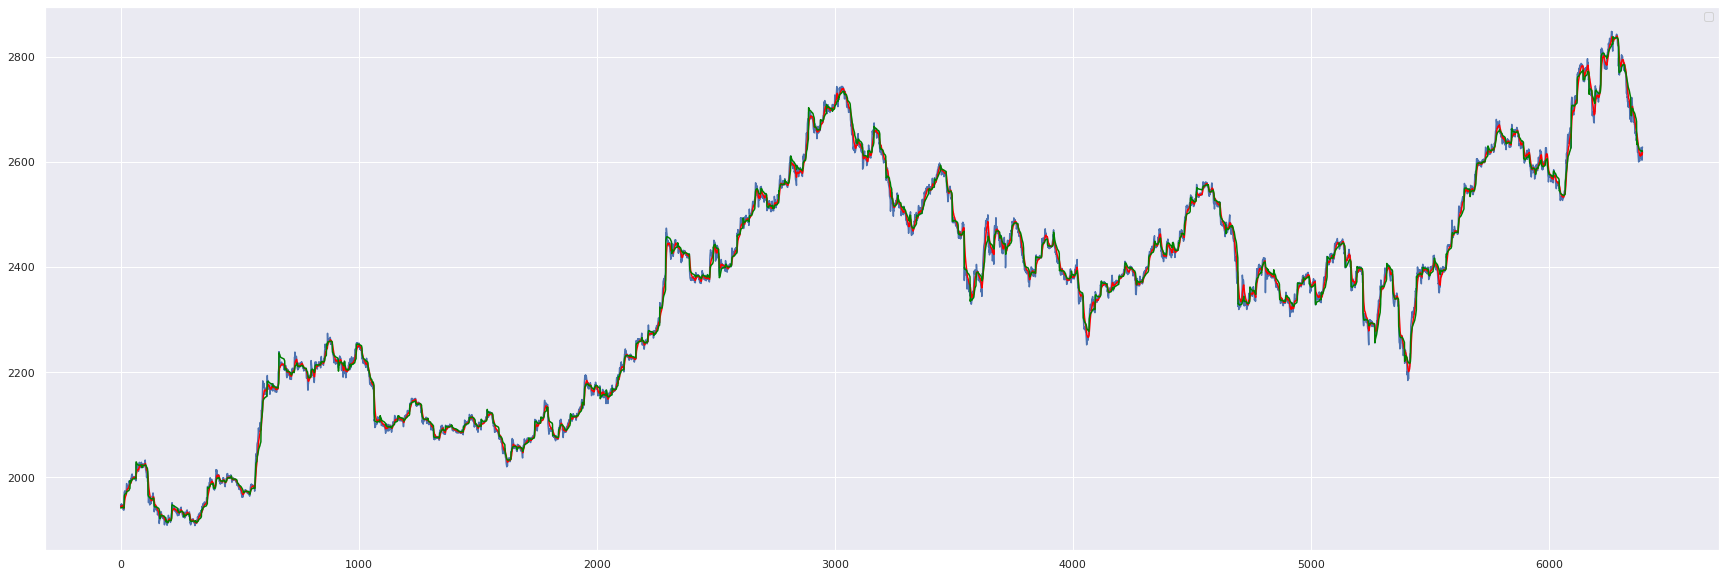

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(price)
plt.plot(ema, color='red')
plt.plot(vwap,color='green')
plt.legend()
plt.show()

In [ ]:

# split a multivariate sequence into samples
# n_steps ---> number of lag observations

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:

ema = np.array(ema).reshape(len(ema), 1)
vwap = np.array(vwap).reshape(len(vwap), 1)
price = np.array(price).reshape(len(price), 1)
dataset = np.hstack((ema, vwap, price))
print(dataset)

[[1944.36681818 1941.6297111  1946.85      ]
 [1944.37285124 1941.71356597 1944.4       ]
 [1944.04142374 1941.75981017 1942.55      ]
 ...
 [2613.05616268 2620.0202848  2603.        ]
 [2615.34593347 2619.75506223 2625.649902  ]
 [2617.64667284 2620.33009701 2628.        ]]


In [ ]:
def split_dataset_by_day(df, data):
    time_format = "%Y-%m-%d %H:%M:%S"
    previous_day = datetime.strptime(df["time"][0], time_format).day
    begin_index = 0
    list_of_dfs = []
    for i in range(len(df)):
        current_day = datetime.strptime(df["time"][i], time_format).day
        if(current_day!=previous_day):
            sample_df = data[begin_index:i]
            list_of_dfs.append(sample_df)
            begin_index = i
        previous_day = current_day
    return list_of_dfs

In [ ]:
test_data = dataset[-908:]
test_df = close_ds.tail(908)
test_df_reindexed = test_df.reset_index(drop=True)

sample_datasets = split_dataset_by_day(test_df_reindexed, test_data)

In [ ]:
# model will be retrained this many times
len(sample_datasets) 

36

(6400, 3, 3) (6400,)
[[1944.36681818 1941.6297111  1946.85      ]
 [1944.37285124 1941.71356597 1944.4       ]
 [1944.04142374 1941.75981017 1942.55      ]] 1942.55
(6392, 3, 3)
(6392,)
(8, 3, 3)
(8,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             448       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
200/200 - 12s - loss: 209816.4062 - val_loss: 11137.8984 - 12s/epoch - 60ms/step
Epoch 2/50
200/200 - 1s - loss: 161.4994 - val_loss: 11130.8135 - 646ms/epoch - 3ms/step
Epoch 3/50
200/200 - 1s - loss: 161.3542 - val_loss: 11268.6895 - 657ms/epoch - 3ms/step
Epoch 4/50
200/200 - 1s - loss: 161.5358 - val_loss: 11025.0713 - 613ms/epoch - 3ms/step
Epoch 5/50
200/200 - 1s - loss: 161.9534 - val_loss: 11190.4658 - 614ms/epoch - 3ms/step
Epoch 6/50
200/200 - 1s - loss: 162.2426 - val_loss: 11176.2725 - 647ms/epoch - 3ms/step
Epoch 7/50
200/200 - 1s - loss: 161.6267 - val_loss: 10972.2803 - 672ms/epoch - 3ms/step
Epoch 8/50
200/200 - 1s - loss: 161.8045 - val_loss: 11095.4941 - 628ms/epoch - 3ms/step
Epoch 9/50
200/200 - 1s - loss: 161.3525 - val_loss: 10932.1611 - 639ms/epoch - 3ms/step
Epoch 10/50
200/200 - 1s - loss: 162.3752 - val_loss: 11096.7178 - 627ms/epoch - 3ms/step
Epoch 11/50
200/200 - 1s - loss: 162.2718 - val_loss: 11192.7568 - 608ms/epoch - 3ms/step
Epoch 12/50
200/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(6925, 3, 3) (6925,)
[[1944.36681818 1941.6297111  1946.85      ]
 [1944.37285124 1941.71356597 1944.4       ]
 [1944.04142374 1941.75981017 1942.55      ]] 1942.55
(6900, 3, 3)
(6900,)
(25, 3, 3)
(25,)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 2, 64)             448       
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 64)                0         
                                                                 
 dense_42 (Dense)            (None, 50)                3250      
                                                                 
 dense_43 (Dense)            (None, 1)          

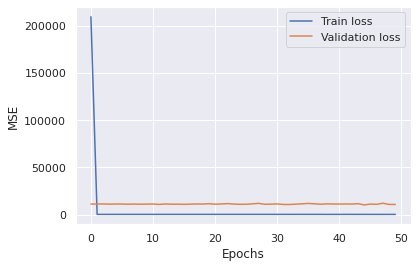

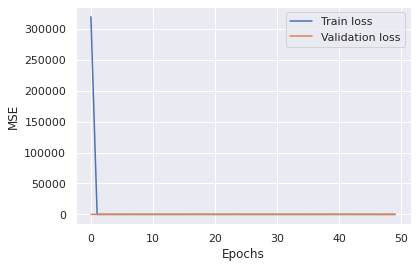

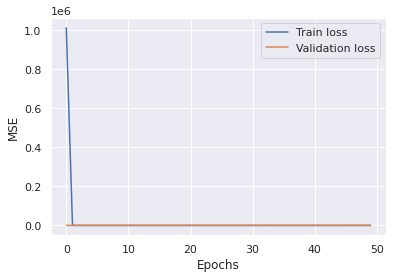

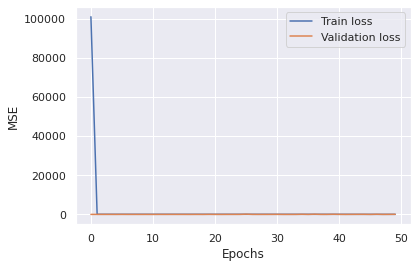

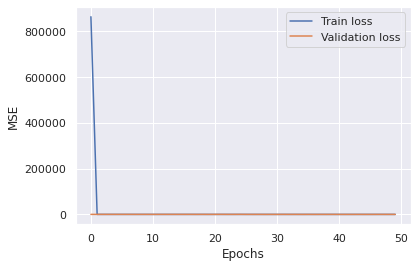

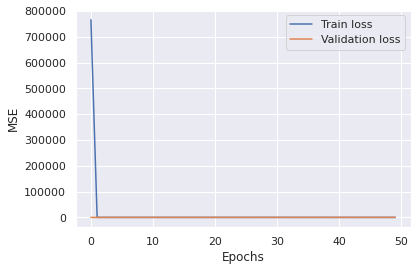

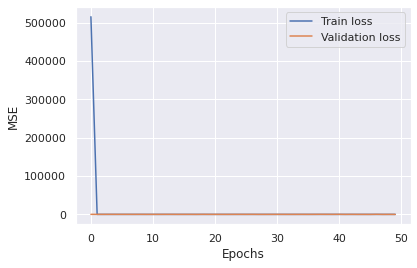

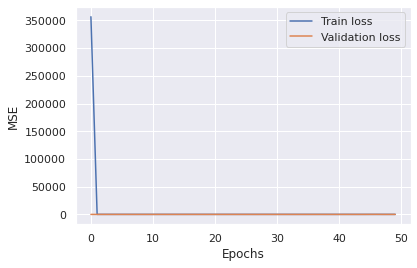

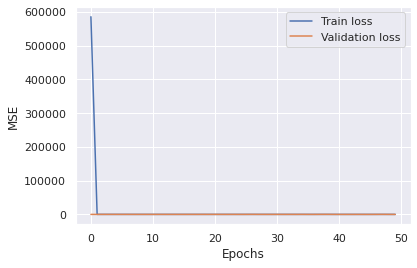

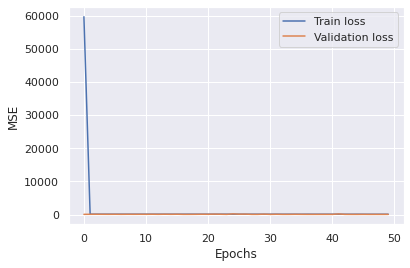

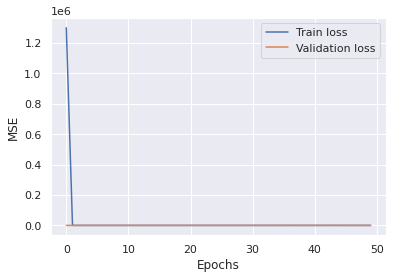

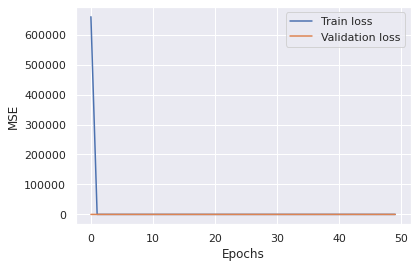

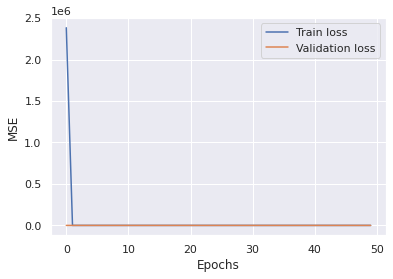

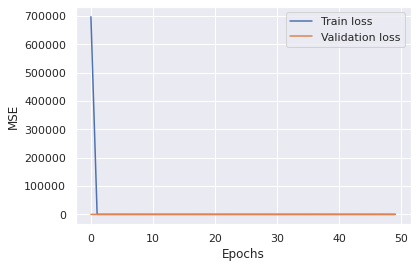

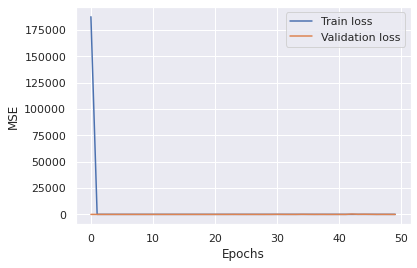

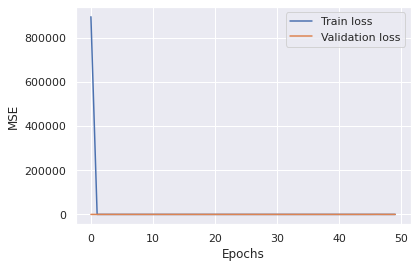

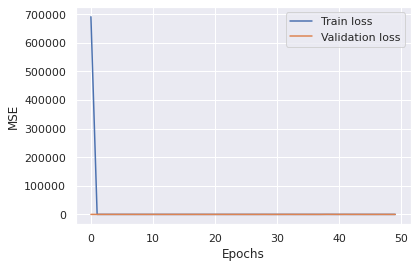

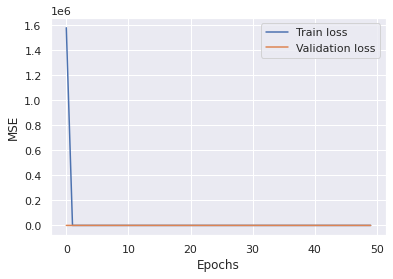

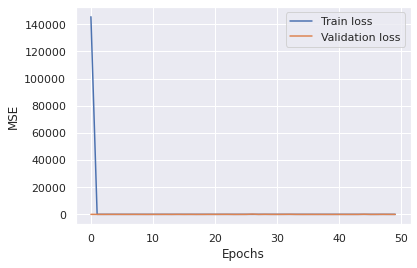

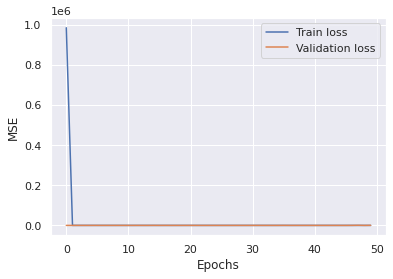

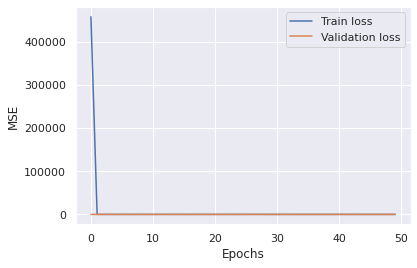

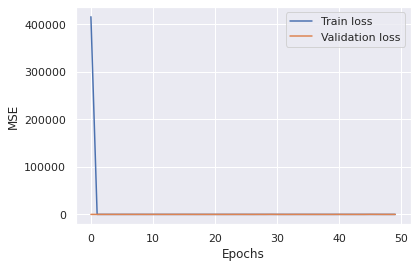

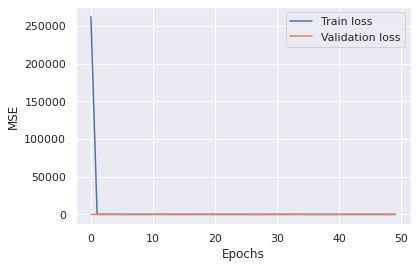

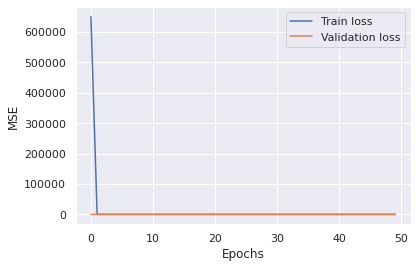

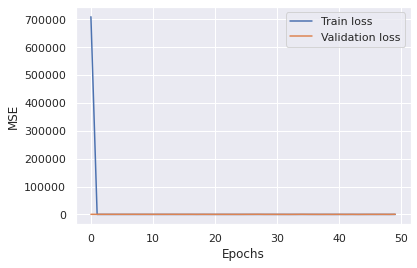

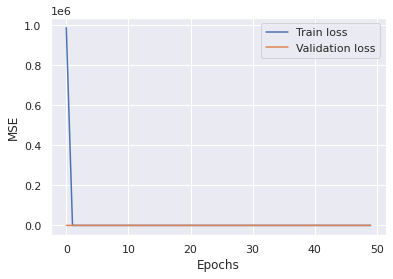

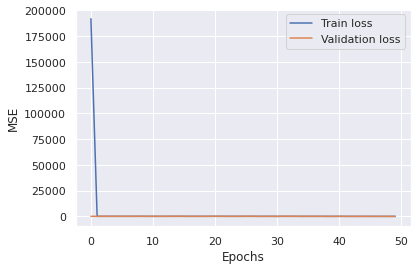

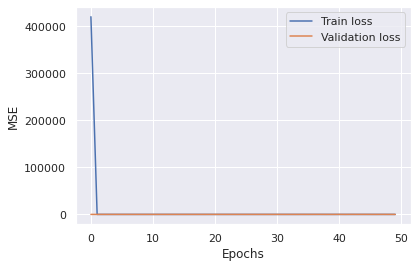

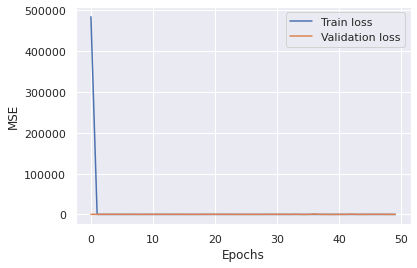

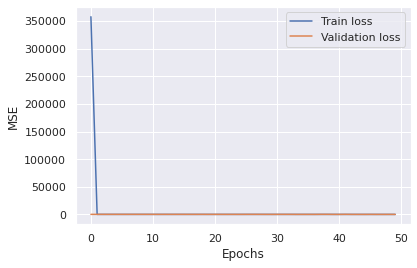

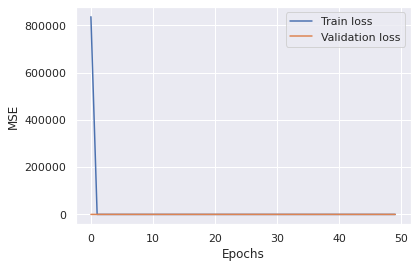

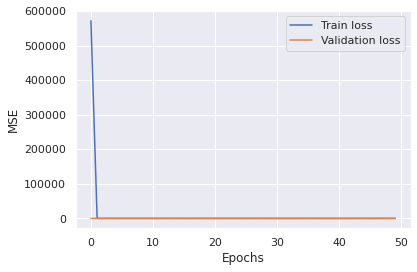

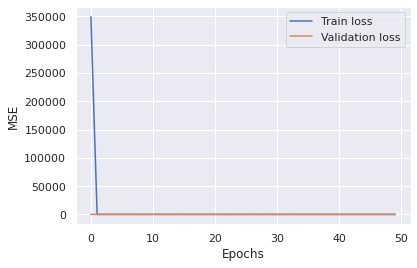

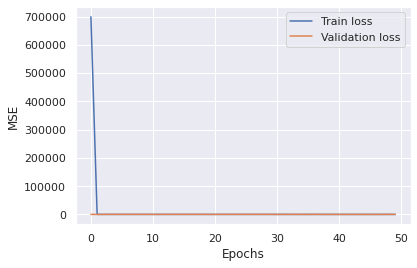

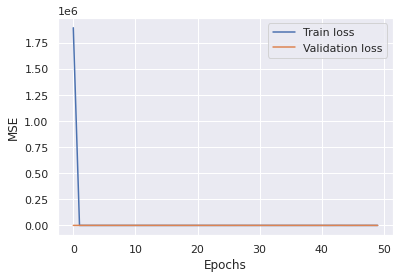

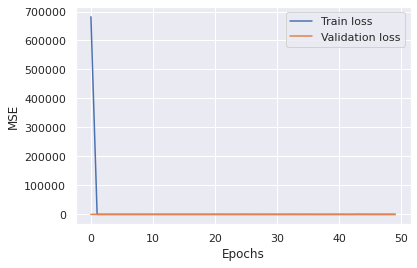

In [ ]:
# gather results across all days
all_test_predictions = []
all_test_actual = []

all_train_predictions = []
all_train_actual = []

for today in sample_datasets:
  # concatenate dataset to be used for training
  dataset = np.concatenate((dataset,today))
  # prediciton will be done on number of datapoints in todays date

  n_steps = 3 
  X, y = split_sequences(dataset, n_steps)
  print(X.shape, y.shape)
  print(X[0], y[0])
  
  from sklearn.model_selection import train_test_split

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=len(today), random_state=42, shuffle=False)
  print(X_train.shape)
  print(y_train.shape)
  print(X_test.shape)
  print(y_test.shape)

  # Model training

  from tensorflow import keras 
  from keras import optimizers
  from keras.models import Sequential, Model
  from keras.layers.convolutional import Conv1D, MaxPooling1D
  from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

  # CNN

  model_cnn = Sequential()
  model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
  model_cnn.add(MaxPooling1D(pool_size=2))
  model_cnn.add(Flatten())
  model_cnn.add(Dense(50, activation='relu'))
  model_cnn.add(Dense(1))
  model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
  model_cnn.summary()

  cnn_history = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=2)

  # plots 
  fig = plt.figure()
  plt.plot(cnn_history.history['loss'], label='Train loss')
  plt.plot(cnn_history.history['val_loss'], label='Validation loss')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('MSE')

  # RMSE calculation
  from sklearn.metrics import mean_squared_error
  cnn_train_pred = model_cnn.predict(X_train)
  cnn_test_pred = model_cnn.predict(X_test)
  
  all_test_predictions.append(cnn_test_pred.flatten())
  all_test_actual.append(y_test)

  all_train_predictions.append(cnn_train_pred.flatten())
  all_train_actual.append(y_train)

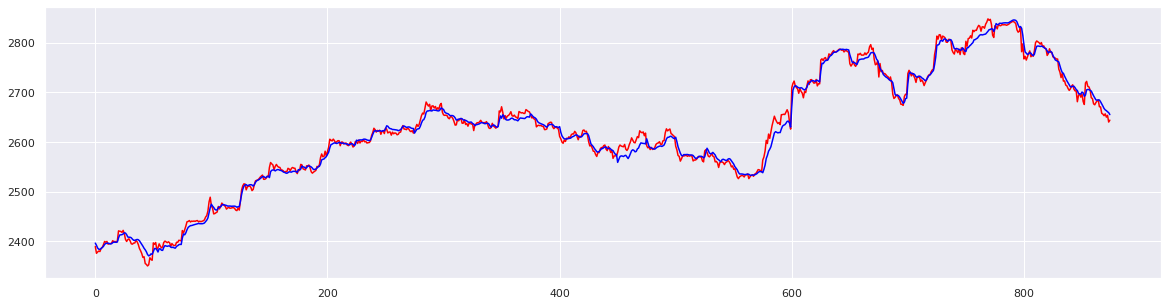

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(np.concatenate(all_test_actual[1:], axis=0), color='red')
plt.plot(np.concatenate(all_test_predictions[1:], axis=0), color='blue')

In [ ]:
print('Test rmse:', np.sqrt(mean_squared_error(np.concatenate(all_test_predictions, axis=0), np.concatenate(all_test_actual, axis=0))))


Test rmse: 14.213273965326508
